In [1]:
import os
import io
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') 

In [2]:
data = pd.read_csv("listings.csv.gz") 
data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2060,https://www.airbnb.com/rooms/2060,20200313233810,2020-03-14,Modern NYC,NaN,"Lovely, spacious, sunny 1 BR apartment in 6th ...","Lovely, spacious, sunny 1 BR apartment in 6th ...",none,NaN,...,f,f,flexible,f,f,1,0,1,0,0.01
1,2595,https://www.airbnb.com/rooms/2595,20200313233810,2020-03-14,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.38
2,3831,https://www.airbnb.com/rooms/3831,20200313233810,2020-03-14,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.71
3,5099,https://www.airbnb.com/rooms/5099,20200313233810,2020-03-14,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.59
4,5114,https://www.airbnb.com/rooms/5114,20200313233810,2020-03-14,Super Room in Great area.,NaN,"First, the area is PERFECT if you want to visi...","First, the area is PERFECT if you want to visi...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,1,2,0,0.56


In [3]:
len(data)

50796

In [5]:
#to get a count of missing values for each column, and what percent of each column is null 
data.isnull().sum()

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum())/data.isnull().count().sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(25)

,Total,Percent
thumbnail_url,50796,1.000000
xl_picture_url,50796,1.000000
medium_url,50796,1.000000
jurisdiction_names,50781,0.999705
license,50759,0.999272
square_feet,50407,0.992342
monthly_price,46119,0.907926
weekly_price,45411,0.893988
notes,30273,0.595972
access,23984,0.472163


In [6]:
#remove columns with 50% or more null values 
   
data.drop(['thumbnail_url','xl_picture_url','medium_url','jurisdiction_names','license','square_feet','monthly_price','weekly_price','notes'], axis=1, inplace=True)


In [8]:
#fill certain attributes with 0 if n/a 
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)
data['bathrooms'] = data['bathrooms'].fillna(0)
data['bedrooms'] = data['bedrooms'].fillna(0)
data['security_deposit'] = data['security_deposit'].fillna(0)
data['space'] = data['space'].fillna(0)

In [10]:
#data exploration: see which hosts have the most listings
host_listings=data.host_id.value_counts().head(10)
host_listings

107434423    302
219517861    297
137358866    136
30283594     116
16098958     112
61391963     109
48005494     103
51501835      92
12243051      89
22541573      88
Name: host_id, dtype: int64

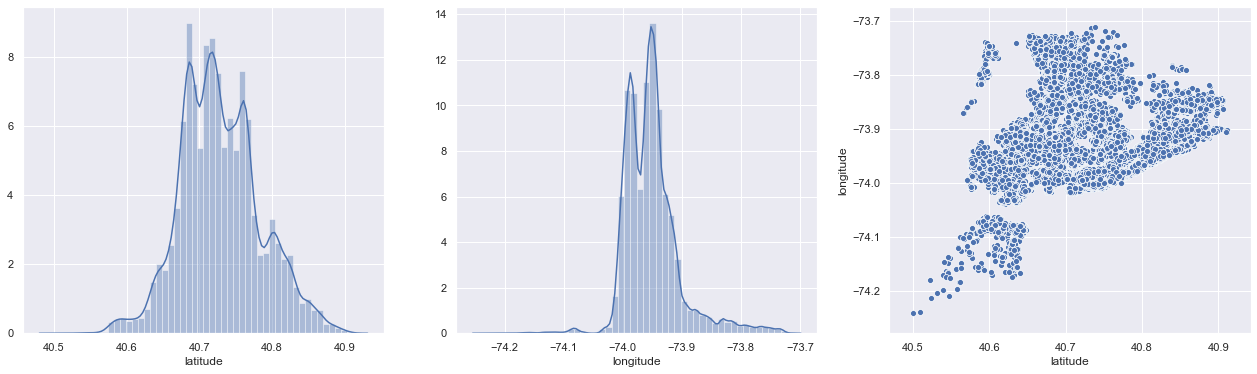

In [24]:
#visualization for latitude/longitude concentration areas
fig, axes = plt.subplots(1,3, figsize=(22,6))
sns.distplot(data['latitude'], ax=axes[0])
sns.distplot(data['longitude'], ax=axes[1])
sns.scatterplot(x= data['latitude'], y=data['longitude'])

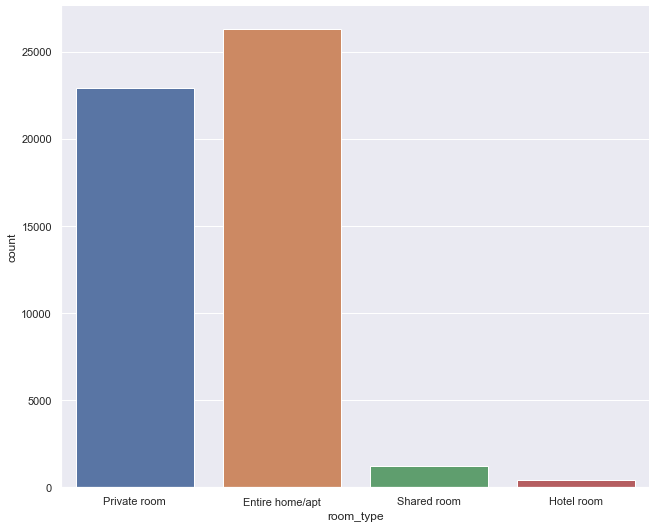

In [26]:
#visualization for type of room
sns.catplot(x='room_type', kind='count' ,data=data)
fig = plt.gcf()
fig.set_size_inches(10, 8)

In [3]:
#function to replace
def convert_bool(row):
    row = row.replace('f', '0')
    row = row.replace('t', '1')
    return row


#function to replace
def convert_string_to_int(row):
    row = row.replace('within an hour', '1')
    row = row.replace('within a few hours', '2')
    row = row.replace('within a day', '3')
    row = row.replace('a few days or more', '4')
    return row

In [23]:
#trying out the test/train split for linear regression -- we will put 40% of the dataset as a test

from sklearn.model_selection import train_test_split

X = data["reviews_per_month", "bathrooms", "bedrooms"]
y = data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

NameError: name 'data' is not defined

In [9]:
model = RandomForestClassifier()

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
from yellowbrick.regressor import PredictionError
viz = PredictionError(LinearRegression())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

In [ ]:
from yellowbrick.regressor import ResidualsPlot
viz = ResidualsPlot(LinearRegression())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()